In [ ]:
!pip install pyspark==3.4.1
!pip install pandas
!pip install findspark
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=f364f89c52f681d0620cc98e6155e3aff284dc28bc951d3b5fbd82ad9efdf356
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


Refresher: Basic SQL Operations in Spark SQL

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



Advanced Queries for Data Analysis

In [ ]:
print("total gaji berdasarkan jenis kelamin dan usia")
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

print("Rata-Rata Gaji per departemen")
spark.sql('''
SELECT DeptId, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY DeptId
''').show()

print(" karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing")
spark.sql('''
SELECT e.Name, e.Salary, e.Gender
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Gender
) AS avg_salaries ON e.Gender = avg_salaries.Gender
WHERE e.Salary > avg_salaries.AverageSalary
''').show()

print(" ranking karyawan berdasarkan gaji dalam departemen")
spark.sql('''
SELECT Name, Age, Gender, Salary, DeptId, DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS SalaryRank
FROM employees
''').show()

total gaji berdasarkan jenis kelamin dan usia
+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+

Rata-Rata Gaji per departemen
+------+-------------+
|DeptId|AverageSalary|
+------+-------------+
|     1|       2850.0|
|     2|       4100.0|
+------+-------------+

 karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
+-----+------+------+
| Name|Salary|Gender|
+-----+------+------+
|James|  3000|     M|
+-----+------+------+

 ranking karyawan berdasarkan gaji dalam departemen
+-----+---+------+------+------+----------+
| Name|Age|Gender|Salary|DeptId|SalaryRank|
+-----+---+------+------+------+----------+
|James| 34|     M|  3000|     1|         1|
|  Lee| 23|     M|  2700|     1|         2|
| Anna| 28|     F|  4100|     2|         1|
+-----+---+------+------+------+----------+



Penggunaan Window Functions dan Subqueries

In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



Advanced Spark SQL Queries

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

# Tugas 5: Rata-rata gaji per departemen dan ranking setiap karyawan dalam departemen berdasarkan gaji
print("Tugas 5: Rata-rata Gaji dan Peringkat")
spark.sql('''
WITH AvgSalary AS (
    SELECT DeptId, AVG(Salary) AS AvgDeptSalary
    FROM employees
    GROUP BY DeptId
),
RankedEmployees AS (
    SELECT e.Name, e.Salary, e.DeptId, d.DeptName,
           RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS SalaryRank
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
)
SELECT re.Name, re.Salary, re.DeptName, as.AvgDeptSalary, re.SalaryRank
FROM RankedEmployees re
JOIN AvgSalary as ON re.DeptId = as.DeptId
ORDER BY re.DeptId, re.SalaryRank
''').show()

# Tugas 6: Menggunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen
print("Tugas 6: Tren Gaji Berdasarkan Usia")
spark.sql('''
SELECT e.Age, d.DeptName,
       AVG(e.Salary) OVER (PARTITION BY e.Age, e.DeptId) AS AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, e.Age
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+

Tugas 5: Rata-rata Gaji dan Peringkat
+-----+------+---------+-------------+----------+
| Name|Salary| DeptName|AvgDeptSalary|SalaryRank|
+-----+------+---------+-------------+----------+
|James|  3000|       HR|       2850.0|         1|
|  Lee|  2700|       HR|       2850.0|         2|
| Anna|  4100|Marketing|       4100.0|         1|
+-----+------+---------+-------------+----------+

Tugas 6: Tren Gaji Berdasarkan Usia
+---+---------+---------+
|Age| DeptName|AvgSalary|
+---+---------+---------+
| 23|       HR|   2700.0|
| 34|       HR|   3000.0|
| 28|Marketing|   4100.0|
+---+---------+---------+



Advanced Data Analysis and Visualization

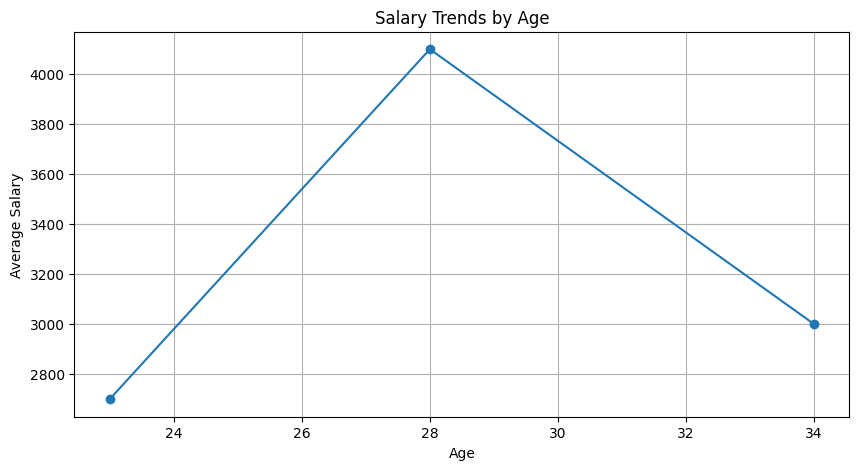

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.



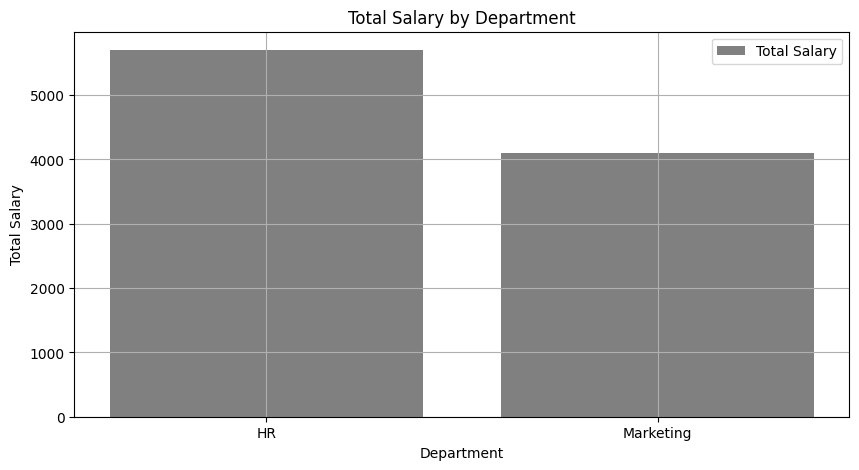

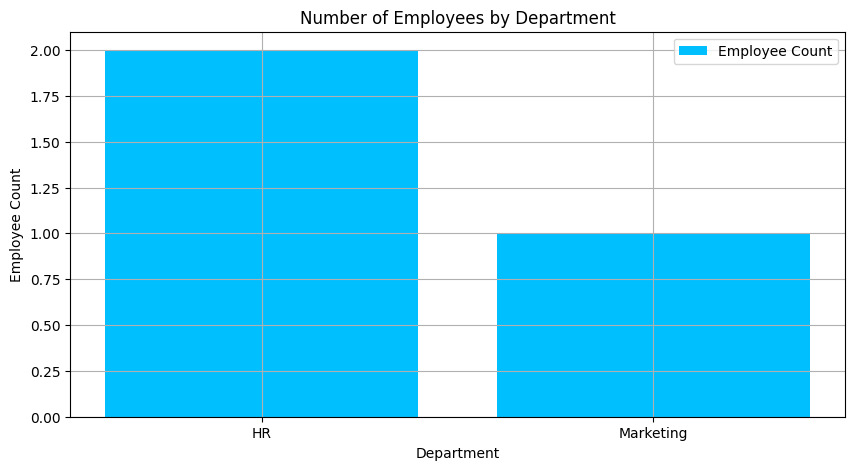

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

# Inisialisasi Spark
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Menjalankan query untuk total gaji dan jumlah karyawan per departemen
salary_count_by_dept = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''').toPandas()

# Visualisasi Total Salary by Department
plt.figure(figsize=(10, 5))
plt.bar(salary_count_by_dept['DeptName'], salary_count_by_dept['TotalSalary'], color='#808080', label='Total Salary')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary by Department')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi Number of Employees by Department
plt.figure(figsize=(10, 5))
plt.bar(salary_count_by_dept['DeptName'], salary_count_by_dept['EmployeeCount'], color='#00bfff', label='Employee Count')
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.title('Number of Employees by Department')
plt.legend()
plt.grid(True)
plt.show()

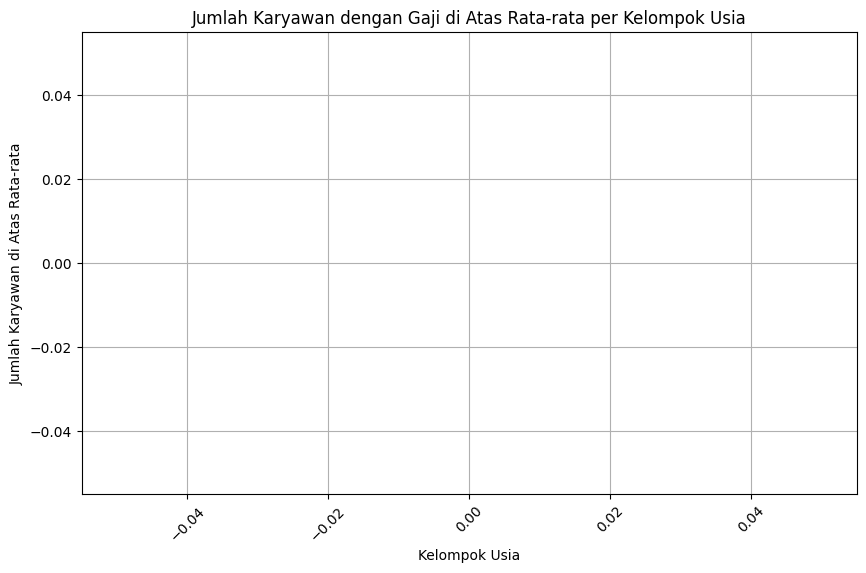

In [ ]:
# Menggunakan SQL untuk menghitung rata-rata gaji per kelompok usia
age_average = spark.sql('''
SELECT Age, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY Age
''')

# Mengambil DataFrame karyawan dan menghitung karyawan di atas rata-rata
above_avg_salaries = spark.sql('''
SELECT e.Age, COUNT(e.Name) AS AboveAvgCount
FROM employees e
JOIN (
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
) AS avgTable ON e.Age = avgTable.Age
WHERE e.Salary > avgTable.AvgSalary
GROUP BY e.Age
ORDER BY e.Age
''').toPandas()

# Visualisasi menggunakan grafik garis
plt.figure(figsize=(10, 6))
plt.plot(above_avg_salaries['Age'], above_avg_salaries['AboveAvgCount'], marker='o', color='#1f77b4')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Karyawan di Atas Rata-rata')
plt.title('Jumlah Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia')
plt.xticks(rotation=45)
plt.grid()
plt.fill_between(above_avg_salaries['Age'], above_avg_salaries['AboveAvgCount'], alpha=0.2)
plt.show()

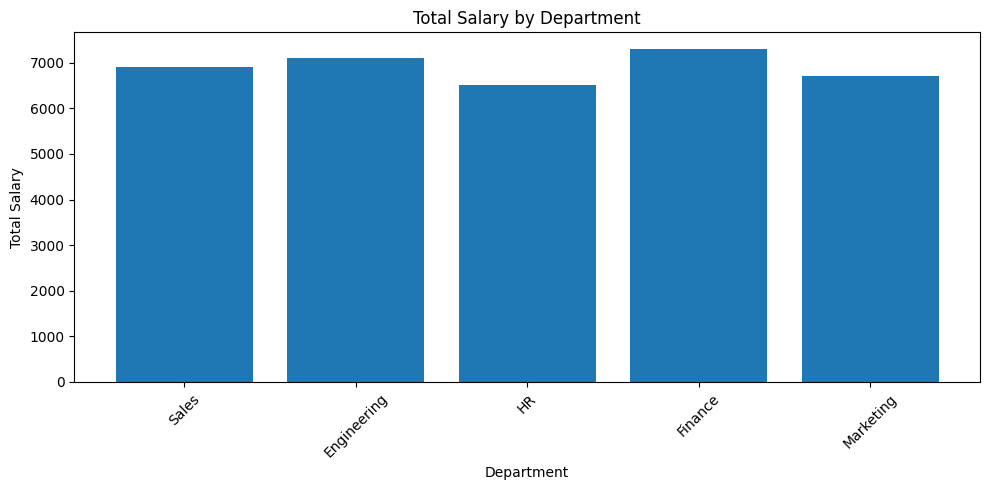

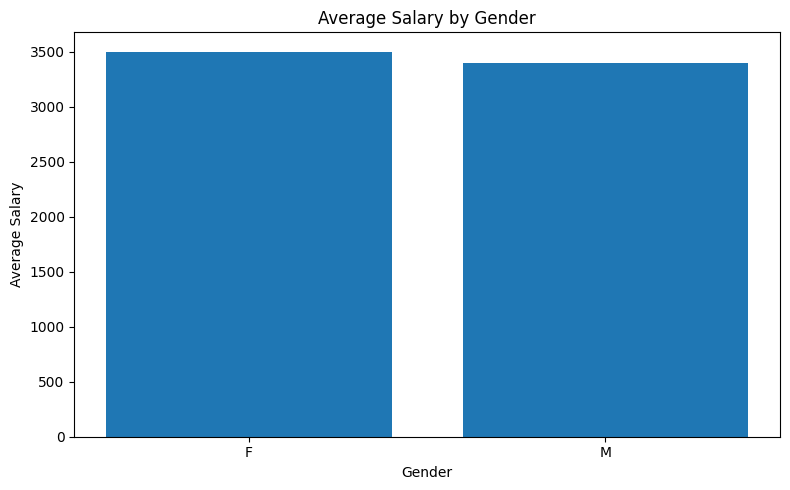

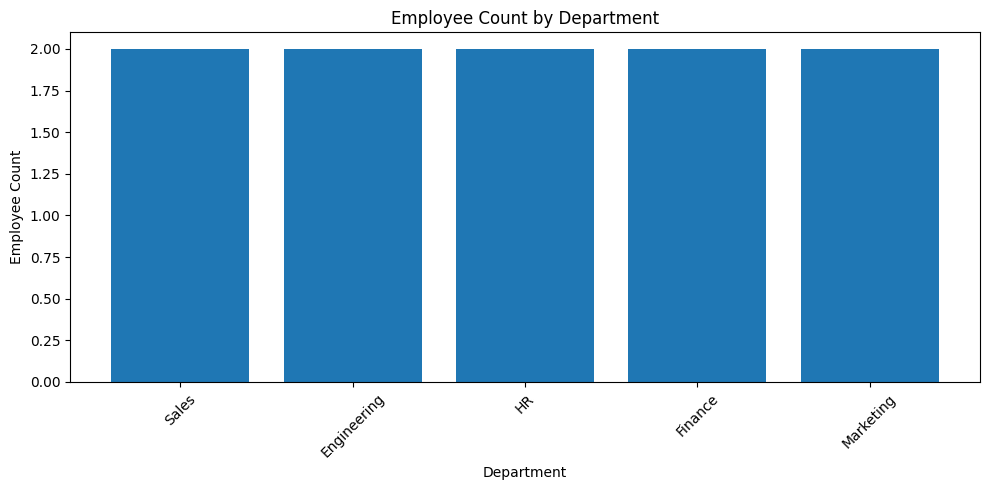

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("SalaryAnalysis").getOrCreate()

# Data karyawan
employee_data = [
    ('Aldo Pradana', 22, 'M', 3000, 1), ('Beatrice Larasati', 23, 'F', 3100, 2),
    ('Cahya Gunawan', 24, 'M', 3200, 3), ('Diana Melati', 25, 'F', 3300, 4),
    ('Eka Santoso', 26, 'M', 3400, 5), ('Fahri Imanuddin', 27, 'F', 3500, 1),
    ('Gita Wulandari', 28, 'M', 3600, 2), ('Hendra Jaya', 29, 'F', 3700, 3),
    ('Intan Wijaya', 30, 'M', 3800, 4), ('Joko Susilo', 31, 'F', 3900, 5),
]

# Buat DataFrame dari data karyawan
columns = ['Name', 'Age', 'Gender', 'Salary', 'DepartmentID']
employees_df = spark.createDataFrame(employee_data, schema=columns)

# Buat temporary view
employees_df.createOrReplaceTempView('employees')

# Data departemen
departments_data = [(1, 'HR'), (2, 'Marketing'), (3, 'Sales'), (4, 'Engineering'), (5, 'Finance')]
departments_df = spark.createDataFrame(departments_data, schema=['DepartmentID', 'DepartmentName'])
departments_df.createOrReplaceTempView('departments')

# Analisis dengan Spark SQL
total_salary_by_dept = spark.sql('''
    SELECT d.DepartmentName, SUM(e.Salary) AS TotalSalary
    FROM employees e
    JOIN departments d ON e.DepartmentID = d.DepartmentID
    GROUP BY d.DepartmentName
''').toPandas()

avg_salary_by_gender = spark.sql('''
    SELECT Gender, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Gender
''').toPandas()

employee_count_by_dept = spark.sql('''
    SELECT d.DepartmentName, COUNT(*) AS EmployeeCount
    FROM employees e
    JOIN departments d ON e.DepartmentID = d.DepartmentID
    GROUP BY d.DepartmentName
''').toPandas()

# Visualisasi Total Gaji per Departemen
plt.figure(figsize=(10, 5))
plt.bar(total_salary_by_dept['DepartmentName'], total_salary_by_dept['TotalSalary'])
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary by Department')
plt.xticks(rotation=45)  # Rotasi label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

# Visualisasi Rata-rata Gaji per Jenis Kelamin
plt.figure(figsize=(8, 5))
plt.bar(avg_salary_by_gender['Gender'], avg_salary_by_gender['AverageSalary'])
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.title('Average Salary by Gender')
plt.tight_layout()
plt.show()

# Visualisasi Jumlah Karyawan per Departemen
plt.figure(figsize=(10, 5))
plt.bar(employee_count_by_dept['DepartmentName'], employee_count_by_dept['EmployeeCount'])
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.title('Employee Count by Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hentikan SparkSession
spark.stop()